# 1. Pre-Procesamiento

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [24]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Fijamos la semilla:

In [25]:
ut.set_seed(42)

Parametros de la notebook:

In [26]:
DATASET_PATH = '../../datasets/ebay'

!mkdir -p {DATASET_PATH}

In [27]:
# Se excluyen categorias con menos de 5 productos.
MIN_PRODUCT_BY_CATEGORY = 5

# Se excluyen prodcutos con un title de mas de 150 caracteres.
MAX_TITLE_TOKENS  = 150

### Funciones helper

In [108]:
def plot_categories(groups, figsize=(10,5)):
    sns.set_theme(style="whitegrid")
    sns.set(rc={"figure.figsize":figsize})
        
    ax = sns.barplot(x='category', y='count', data=groups)
    ax.set(xlabel='')
    ax.set(xticklabels=[])
    plt.show()
    
def plot_title(df, column, title, figsize=(8,4)):
    sns.set_theme(style="whitegrid")
    sns.set(rc={"figure.figsize":figsize})
    
    df = df.sort_values([column], ascending=False)
    ax = sns.barplot(x=column, y='title', data=df)
    
    ax.set(yticklabels=[])
    dt.plot_defaults(ylabel=None, title='')

## Procedimiento

**Step 1**: Cargamos el dataset.

In [87]:
raw_dataset = pd.read_csv(f'{DATASET_PATH}/dataset.csv')

**Step 2**: Renombramos las columnas a title y category.

In [88]:
raw_dataset = raw_dataset[['name', 'breadcrumbs']]
raw_dataset = raw_dataset.rename(columns={'name':'title', 'breadcrumbs': 'category'})
raw_dataset.head()

,title,category
0,2x Ultra-thin LCD Digital Display Vehicle Car ...,"eBay ~ Home, Furniture & DIY ~ Clocks ~ Alarm ..."
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
3,HP LaserJet Enterprise M552DN Colour 1200 X 12...,eBay ~ Computers/Tablets & Networking ~ Printe...
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...


In [89]:
raw_dataset.shape

(3003, 2)

**Step 3**: Nos quedamos con las categorias que tienen como mínimo MIN_PRODUCT_BY_CATEGORY.

In [90]:
groups = ut.group_by_count(raw_dataset, ['category'], 'title')
groups = groups[groups['count'] >= MIN_PRODUCT_BY_CATEGORY ]
groups.tail()

,category,count
692,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5
817,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
773,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
820,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,5
631,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5


In [91]:
groups.shape

(122, 2)

In [92]:
categories = list(set(ut.flatten(raw_dataset['category'].apply(lambda x: x.split('~')).values)))

In [93]:
len(categories)

1275

In [94]:
filtered_dataset = raw_dataset[raw_dataset['category'].isin(groups['category'])]
filtered_dataset.head()

,title,category
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
5,JMT X-ring 530x2 Gold 104 Open Chain With Rive...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
7,1x Summer Tyre Michelin Pilot Sport 4 255/40zr...,eBay ~ Vehicle Parts & Accessories ~ Car Wheel...


In [95]:
filtered_dataset['category'].head().values

array(['eBay ~ Vehicle Parts & Accessories ~ Car Parts ~ Air Conditioning & Heating ~ Pollen Filters',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Bodywork & Frame ~ Windscreens',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Brakes & Brake Parts ~ Brake Pads',
       'eBay ~ Vehicle Parts & Accessories ~ Motorcycle Parts ~ Drivetrain & Transmission ~ Chains & Sprockets',
       'eBay ~ Vehicle Parts & Accessories ~ Car Wheels, Tyres & Trims ~ Tyres'],
      dtype=object)

In [96]:
filtered_dataset['title'].head().values

array(['MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 02 to 05 2909705RMP M166.961 Bosch',
       'Windscreen Kappa Transparent 58x45cm for Aprilia Caponord 1200 2014',
       'Honda RS 250 R 1991-1994 DP Brakes Street Sintered Rear Brake Pads - Dp119',
       'JMT X-ring 530x2 Gold 104 Open Chain With Rivet Link for Kawasaki KH 400 a 1976',
       '1x Summer Tyre Michelin Pilot Sport 4 255/40zr17 98y El'],
      dtype=object)

In [97]:
raw_dataset.shape, filtered_dataset.shape

((3003, 2), (1934, 2))

**Step 4**: Seleccionamos los productos con descripciones menores a MAX_PRODUCT_TITLE_SIZE caracteres.

<Figure size 800x400 with 1 Axes>

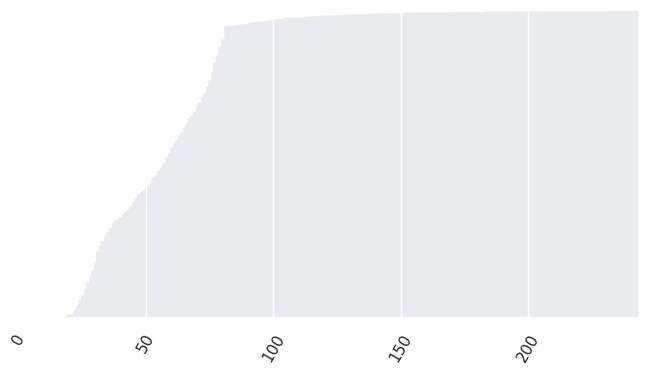

In [98]:
filtered_dataset['title_size'] = filtered_dataset['title'].apply(len)

plot_title(filtered_dataset, column='title_size', title='Product title: Cantidad de caracteres')

<Figure size 800x400 with 1 Axes>

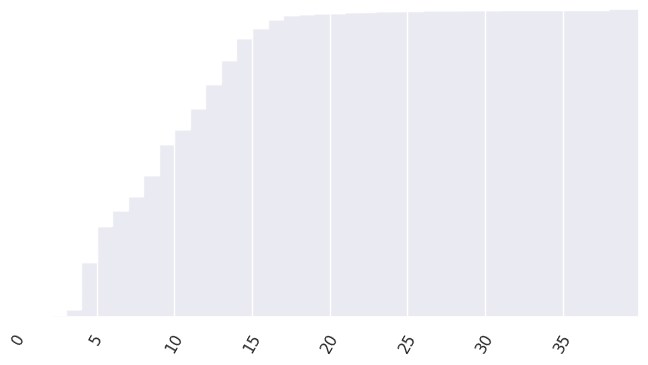

In [99]:
filtered_dataset['tokens_count'] = filtered_dataset['title'].apply(lambda x: len(x.split(' ')))

plot_title(filtered_dataset, column='tokens_count', title='Product title: Cantidad de palabras')

<Figure size 800x400 with 1 Axes>

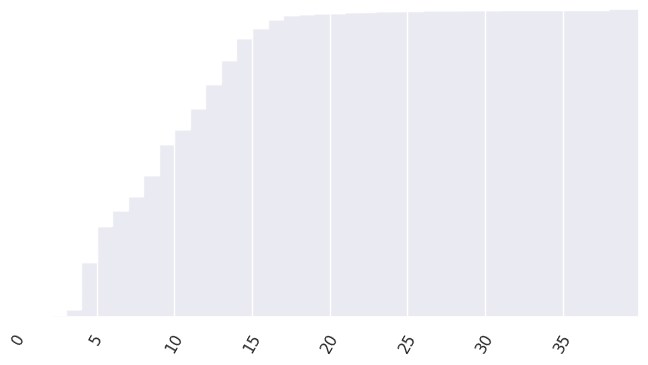

In [100]:
filtered_dataset = filtered_dataset[filtered_dataset['tokens_count'] < MAX_TITLE_TOKENS]

plot_title(filtered_dataset, column='tokens_count', title='Product title: Cantidad de tokens')

In [101]:
filtered_dataset['tokens_count'].min(), filtered_dataset['tokens_count'].max()

(2, 38)

In [102]:
filtered_dataset = filtered_dataset.drop(columns=['title_size'])
filtered_dataset.head()

,title,category,tokens_count
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,14
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,9
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,14
5,JMT X-ring 530x2 Gold 104 Open Chain With Rive...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...,16
7,1x Summer Tyre Michelin Pilot Sport 4 255/40zr...,eBay ~ Vehicle Parts & Accessories ~ Car Wheel...,10


**Step 5**: Agregamos un número de secuencia que representa univocamente a cada categoria.

In [103]:
filtered_dataset = dt.Sequencer('category', 'category_seq').perform(filtered_dataset)
filtered_dataset.head()

,title,category,tokens_count,category_seq
0,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,14,0
1,Pollen / Cabin Filter Fits Toyota Camry V3 2.4...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,15,0
2,K&n Filters VF1000 Cabin Air Filter,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,6,0
3,Pollen / Cabin Filter Fits HYUNDAI Veloster FS...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,15,0
4,Blue Print ADU172504 Cabin Filter,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,5,0


In [104]:
filtered_dataset['category_seq'].min(), filtered_dataset['category_seq'].max()

(0, 121)

**Step 6**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minimasr el efecto del desbalanceo de prodxcutos por categoria.

In [105]:
train_set, test_set, _, _= train_test_split(
    filtered_dataset,
    filtered_dataset['category'].values,
    test_size     = 0.1,
    stratify      = filtered_dataset['category'].values,
    shuffle       = True
)

In [106]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['category'].values,
    test_size     = 0.5,
    shuffle       = False
)

**Step 7**: Chequeamos que en test y evaliacion existan las misma categorias que existe en train.

<Figure size 1000x500 with 1 Axes>

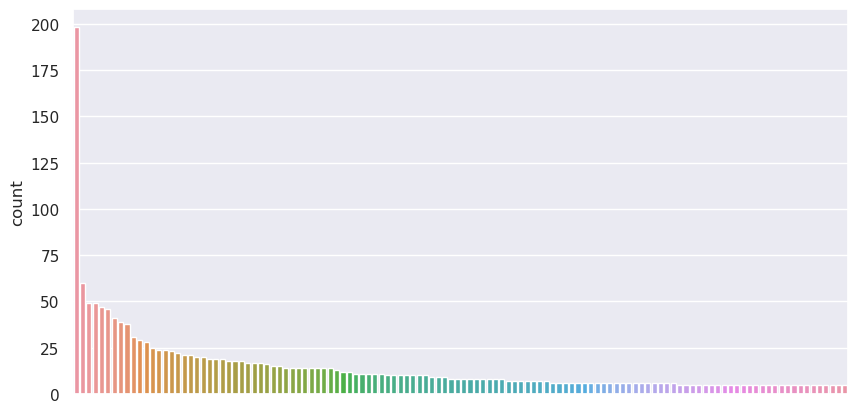

In [109]:
plot_categories(ut.group_by_count(train_set, ['category'], 'title'))

<Figure size 1000x500 with 1 Axes>

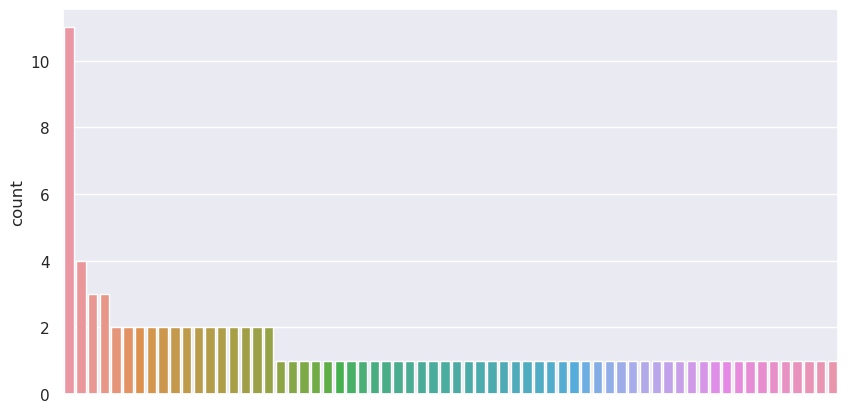

In [110]:
plot_categories(ut.group_by_count(test_set, ['category'], 'title'))

<Figure size 1000x500 with 1 Axes>

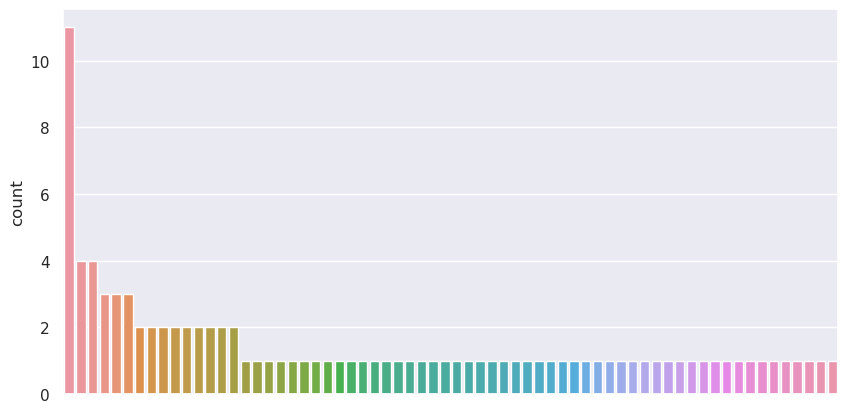

In [111]:
plot_categories(ut.group_by_count(val_set, ['category'], 'title'))

In [112]:
train_set.shape, val_set.shape, test_set.shape

((1740, 4), (97, 4), (97, 4))

Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción:

In [113]:
val_set[val_set['category'].isin(train_set['category'].values)].shape

(97, 4)

In [114]:
test_set[test_set['category'].isin(train_set['category'].values)].shape

(97, 4)

**Step 8**: Guardamos todos los conjuntos preprocesados.

In [115]:
train_set       .to_csv(f'{DATASET_PATH}/train.csv', index=False)
val_set         .to_csv(f'{DATASET_PATH}/val.csv',   index=False)
test_set        .to_csv(f'{DATASET_PATH}/test.csv',  index=False)
filtered_dataset.to_csv(f'{DATASET_PATH}/all.csv',   index=False)